# Практическое задание

Иванычев Сергей Дмитриевич, группа 376 (база с 374-й)

[email](mailto:sergeyivanychev@gmail.com)

### Задача Bike Sharing

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной псотановке задачи доступно 9 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

### Анализ и визуализация данных

In [1]:
from sklearn import cross_validation, ensemble, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("bike_sharing_train.csv")

In [4]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["year"] = df["datetime"].apply(lambda x: x.year)
df["hour"] = df["datetime"].apply(lambda x: x.hour)
cols = df.columns.tolist()
cols = cols[:9] + cols[10:] + cols[9:10]
df = df[cols]
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,2011,0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2011,1,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,2011,2,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,2011,3,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,2011,4,1


3 . Проанализируйте описание данных:

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***count*** - number of total rentals

До выполнения задания кажется, что наибольший вес у _season, holiday, working day_ и часа суток

Абсолютная дата, _atemp_

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


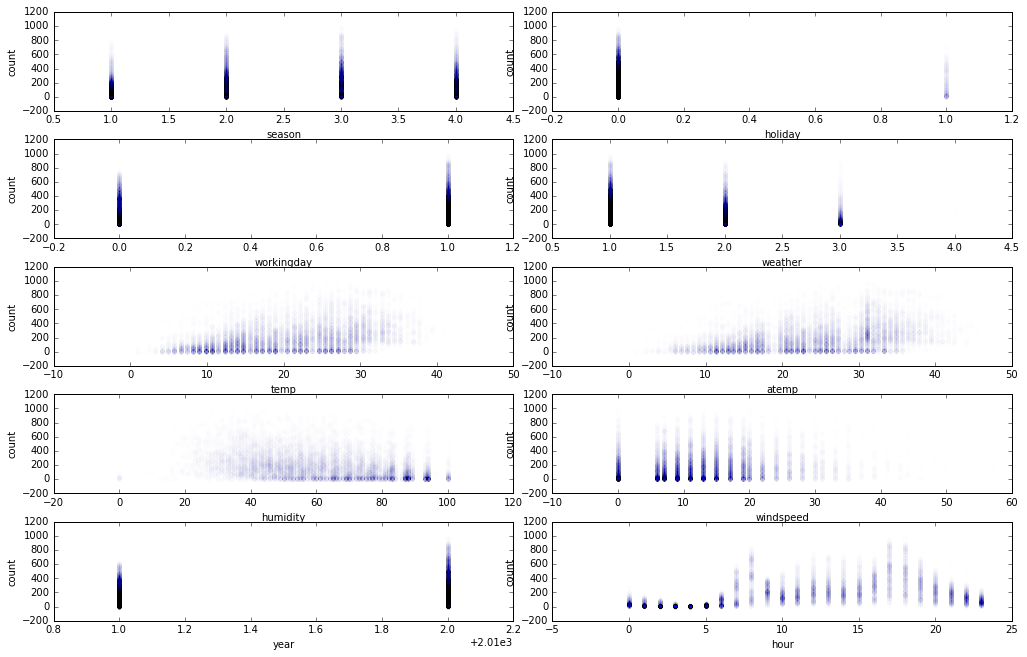

In [5]:
names = list(df.columns.values)[1:-1]
num_plots = len(names)
subplot_width = 2
fig, axes = plt.subplots(num_plots // subplot_width + num_plots % subplot_width, subplot_width, figsize=(14, 9))
fig.tight_layout()
for i, name in enumerate(names):
    plt.subplot(num_plots // subplot_width + num_plots % subplot_width, subplot_width, i + 1)
    plt.xlabel(name)
    plt.ylabel("count")
    plt.scatter(df[name], df["count"], alpha=0.005)

In [6]:
print(df["year"].value_counts())

2012    5464
2011    5422
Name: year, dtype: int64


Сложно что-то конкретное сказать по этим графикам. По графику count/year хочется сказать, что в 2012 году люди с большей охотой брали велосипеды. В рабочие дни велосипеды брали с большей охотой, чем в выходные.

In [7]:
corrs = []
for name in names:
    corr = df[[name, "count"]].corr().ix[0, 1]
    corrs.append((name, corr))
corrs

[('season', 0.16343901657637019),
 ('holiday', -0.0053929844777740425),
 ('workingday', 0.011593866091574248),
 ('weather', -0.12865520103850703),
 ('temp', 0.39445364496725355),
 ('atemp', 0.38978443662698026),
 ('humidity', -0.31737147887659395),
 ('windspeed', 0.10136947021033568),
 ('year', 0.26040329737829015),
 ('hour', 0.40060119414684681)]

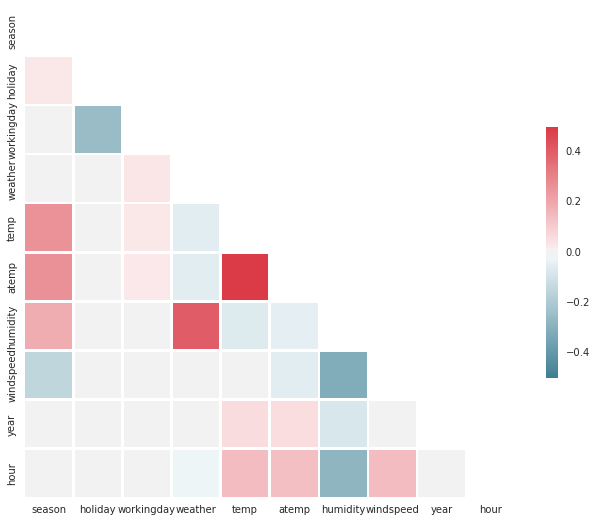

In [8]:
import seaborn as sns

sns.set(style="white")
corr = df[names].corr()

# making upper triangle zeros
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=1.5, cbar_kws={"shrink": .5}, ax=ax)

Да, есть

* `temp` и `atemp` ожидаемо коррелируют
* влажность и температуры коррелируют с временем года

In [9]:
print("Means: \n")
print(df[names].mean())
print("\nStandard deviation: \n")
print(df[names].std())


Means: 

season           2.506614
holiday          0.028569
workingday       0.680875
weather          1.418427
temp            20.230860
atemp           23.655084
humidity        61.886460
windspeed       12.799395
year          2011.501929
hour            11.541613
dtype: float64

Standard deviation: 

season         1.116174
holiday        0.166599
workingday     0.466159
weather        0.633839
temp           7.791590
atemp          8.474601
humidity      19.245033
windspeed      8.164537
year           0.500019
hour           6.915838
dtype: float64


Масштабы сильно отличаются. Это может привести к некорректным результатам некоторых алгоритмов машинного обучения (например SVM). Однако, например, решающие деревья нормально отрабатывают даже при раличных масштабах.

### Линейные модели

In [10]:
X = df[names].as_matrix()
y = df["count"].as_matrix()

In [11]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

In [12]:
def test_sgd_lasso(X, y):
    cv = cross_validation.KFold(y.shape[0], shuffle=True, n_folds=5)
    sgd_scores = []
    lasso_scores = []
    for train, test in cv:
        sgd = linear_model.SGDRegressor()
        lasso = linear_model.Lasso()
        sgd.fit(X[train], y[train])
        lasso.fit(X[train], y[train])
        sgd_pred = sgd.predict(X[test])
        lasso_pred = lasso.predict(X[test])
        sgd_scores.append(metrics.mean_absolute_error(y[test], sgd_pred))
        lasso_scores.append(metrics.mean_absolute_error(y[test], lasso_pred))
    sgd_scores = np.array(sgd_scores)
    lasso_scores = np.array(lasso_scores)
    return sgd_scores, lasso_scores

sgd_scores, lasso_scores = test_sgd_lasso(X, y)
print("SGD mean error: %f, std: %f" %(np.mean(sgd_scores), np.std(sgd_scores)))
print("Lasso mean error: %f, std: %f" % (np.mean(lasso_scores), np.std(lasso_scores)))

SGD mean error: 106.234804, std: 1.998387
Lasso mean error: 106.179682, std: 1.642755


In [13]:
sgd = linear_model.SGDRegressor()
lasso = linear_model.Lasso()
sgd.fit(X, y)
lasso.fit(X, y)
print("SGD weights: ")
for item in zip(names, sgd.coef_):
    print(item)
print("\nLasso weights: ")
for item in zip(names, lasso.coef_):
    print(item)

SGD weights: 
('season', 26.401096590359447)
('holiday', -0.95857173923683614)
('workingday', 1.3731047919081165)
('weather', -1.7030097567760893)
('temp', 18.807348507018816)
('atemp', 32.866663348371446)
('humidity', -35.770952402747675)
('windspeed', 4.1520358499814716)
('year', 41.129017991851001)
('hour', 52.411821394046243)

Lasso weights: 
('season', 23.293977047607992)
('holiday', -0.9120587538367525)
('workingday', 0.0)
('weather', -2.4556761327117389)
('temp', 14.398654277708166)
('atemp', 37.837366462119284)
('humidity', -38.114354230880764)
('windspeed', 3.908927878699743)
('year', 40.452721595729066)
('hour', 53.257360049068133)


По весам можно заключить, что наибольший вес составляют признаки: час, год, влажность и feels like температрура 

Удалим столбец "год", чтобы отвязаться от времени и на 100% честно использовать кросс-валидацию. Добавим признаки "идет ли дождь", "день недели" и "время суток"

In [14]:
# Кроме уже сгенерированных year и hour
def get_part_of_the_day(hour):
    assert hour <= 24
    
    if hour in range(4, 11):
        return 1
    if hour in range(11, 17):
        return 2
    if hour in range(17, 23):
        return 3
    return 4

df_copy = df.copy()
df_copy["is_raining"] = df_copy["weather"].apply(lambda x: 1 if x in [3, 4] else 0)
df_copy["day_part"] = df_copy["hour"].apply(lambda x: get_part_of_the_day(x))
df_copy["day_part_3hour"] = df_copy["hour"].apply(lambda x: x // 3)
df_copy["weekday"] = df_copy["datetime"].apply(lambda x: x.weekday())
df_copy.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,count,is_raining,day_part,day_part_3hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,2011,0,16,0,4,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2011,1,40,0,4,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,2011,2,32,0,4,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,2011,3,13,0,4,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,2011,4,1,0,1,1,5


In [23]:
col_names = list(df_copy.columns.values)
col_names.remove("datetime")
col_names.remove("count")
col_names.remove("year")
names = col_names
X = df_copy[names].as_matrix()
y = df_copy["count"].as_matrix()
X = preprocessing.StandardScaler().fit_transform(X)

sgd_scores, lasso_scores = test_sgd_lasso(X, y)
print("SGD mean error: %f, std: %f" % (np.mean(sgd_scores), np.std(sgd_scores)))
print("Lasso mean error: %f, std: %f" % (np.mean(lasso_scores), np.std(lasso_scores)))
sgd.fit(X, y)
lasso.fit(X, y)
print("SGD weights: ")
for item in zip(names, sgd.coef_):
    print(item)
print("\nLasso weights: ")
for item in zip(names, lasso.coef_):
    print(item)

SGD mean error: 106.961250, std: 1.839373
Lasso mean error: 106.533954, std: 1.996581
SGD weights: 
('season', 21.68405238310071)
('holiday', -0.67092853116842743)
('workingday', 1.7159713620402819)
('weather', 8.5248187644167466)
('temp', 24.886425651920248)
('atemp', 32.826097487879565)
('humidity', -43.081846680856692)
('windspeed', 1.897428719755399)
('hour', 37.797353524636542)
('is_raining', -14.034441464376064)
('day_part', -32.373901196549674)
('day_part_3hour', 14.384396128413581)
('weekday', 4.5087330770556964)

Lasso weights: 
('season', 22.498871521131868)
('holiday', -0.54664268022648999)
('workingday', 0.0)
('weather', 1.6303921221988902)
('temp', 19.653928025009442)
('atemp', 35.083828301794398)
('humidity', -40.355280889456111)
('windspeed', 1.1444898899291696)
('hour', 56.556930005331935)
('is_raining', -8.7611175501347969)
('day_part', -30.473325958120395)
('day_part_3hour', 0.0)
('weekday', 0.0)


Не смотря на то, что мы убрали значимый признак "год", мы стали получать немного лучший результат.

In [16]:
print(df.shape)
treshold = 8000
train_data = df[df.columns.values[1:-1]].iloc[:treshold, :]
train_labels = df[df.columns.values[-1]].iloc[:treshold]
test_data = df[df.columns.values[1:-1]].iloc[treshold:, :]
test_labels = df[df.columns.values[-1]].iloc[treshold:]

(10886, 12)


In [17]:
# Пример:
# train_data, train_labels - DataFrame с обучающей выборкой и значения целевой функции на обучении
# test_data, test_labels - DataFrame с тестовой выборкой и значения целевой функции на тесте



# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

139.3038729112105

In [18]:
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour
0,1,0,0,1,9.84,14.395,81,0.0,2011,0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1
2,1,0,0,1,9.02,13.635,80,0.0,2011,2
3,1,0,0,1,9.84,14.395,75,0.0,2011,3
4,1,0,0,1,9.84,14.395,75,0.0,2011,4


In [19]:
def get_indexes(names, df):
    return np.array([(column in names) for column in df.columns], dtype = bool)

names = ["holiday", "workingday", "temp", "atemp", "humidity", "windspeed", "season", "weather"]

binary_idx  = get_indexes(["holiday", "workingday"], train_data)
number_idx  = get_indexes(["temp", "atemp", "humidity", "windspeed"], train_data)
nominal_idx = get_indexes(["season", "weather"], train_data)

def get_pipeline(model, binary_idx, number_idx, nominal_idx):
    binary_routine = ("binary_selection", preprocessing.FunctionTransformer(lambda data: data[:, binary_idx]))

    numeric_selection_routine = ("numeric_selection", preprocessing.FunctionTransformer(lambda data: data[:, number_idx]))
    numeric_scaling_routine = ("numeric_scaling", preprocessing.StandardScaler())
    numeric_routine = ("numeric_routine", pipeline.Pipeline(steps = [numeric_selection_routine, numeric_scaling_routine]))

    nominal_selection_routine = ("nominal_selection", preprocessing.FunctionTransformer(lambda data: data[:, nominal_idx]))
    nominal_encoding_routine = ("nominal_encoder", preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
    nominal_routine = ("nominal_routine", pipeline.Pipeline(steps = [nominal_selection_routine, nominal_encoding_routine]))

    features_routine = ("features_routine", 
                        pipeline.FeatureUnion(transformer_list=[binary_routine, numeric_routine, nominal_routine]))
    fitting_routine = ("model_fitting", model)

    estimator = pipeline.Pipeline(steps = [features_routine, fitting_routine])
    return estimator

sgd_estimator = get_pipeline(linear_model.SGDRegressor(random_state = 0), binary_idx, number_idx, nominal_idx)
lasso_estimator = get_pipeline(linear_model.Lasso(random_state=0),  binary_idx, number_idx, nominal_idx)

In [20]:
print(train_data.shape)
print(test_data.shape)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(train_data[names])
X_test = scaler.transform(test_data[names])

plain_sgd = linear_model.SGDRegressor()
plain_sgd.fit(X_train, train_labels)
print(metrics.mean_absolute_error(test_labels, plain_sgd.predict(X_test)))

plain_lasso = linear_model.Lasso()
plain_lasso.fit(X_train, train_labels)
print(metrics.mean_absolute_error(test_labels, plain_lasso.predict(X_test)))

sgd_estimator.fit(train_data, train_labels)
print(metrics.mean_absolute_error(test_labels, sgd_estimator.predict(test_data)))

lasso_estimator.fit(train_data, train_labels)
print(metrics.mean_absolute_error(test_labels, lasso_estimator.predict(test_data)))

(8000, 10)
(2886, 10)
155.172985738
154.551335761
150.651300922
152.126293479


Вопреки моим ожиданиям, базовые регрессоры не особо хуже чем пайплайны с преобразованием номинальных признаков в данной метрике.

In [43]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import uniform

sgd_param_grid = {'alpha': uniform.rvs(loc=0, scale=0.0001, size=100)}
lasso_param_grid = {'alpha': uniform.rvs(loc=0, scale=1, size=100)}

sgd_grid_est = get_pipeline(RandomizedSearchCV(linear_model.SGDRegressor(random_state=0), 
                            param_distributions=sgd_param_grid, 
                            scoring='mean_absolute_error',
                            n_iter = 40), 
                            binary_idx, number_idx, nominal_idx)
lasso_grid_est = get_pipeline(RandomizedSearchCV(linear_model.Lasso(random_state=0), 
                            param_distributions=lasso_param_grid, 
                            scoring='mean_absolute_error',
                            n_iter = 40),  
                            binary_idx, number_idx, nominal_idx)

print("SGD")
sgd_grid_est.fit(train_data, train_labels)
for params, mean_score, scores in sgd_grid_est.get_params()["model_fitting"].grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
print(metrics.mean_absolute_error(test_labels, sgd_grid_est.predict(test_data)))

print("\nLasso")
lasso_grid_est.fit(train_data, train_labels)
for params, mean_score, scores in lasso_grid_est.get_params()["model_fitting"].grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
print(metrics.mean_absolute_error(test_labels, lasso_grid_est.predict(test_data)))

SGD
-109.052 (+/-24.149) for {'alpha': 4.728767702498458e-05}
-109.052 (+/-24.148) for {'alpha': 3.1540176713648475e-05}
-109.052 (+/-24.150) for {'alpha': 6.8365771687554352e-05}
-109.052 (+/-24.150) for {'alpha': 6.2139454877360465e-05}
-109.052 (+/-24.150) for {'alpha': 7.2778603601769451e-05}
-109.052 (+/-24.150) for {'alpha': 5.5152256373180955e-05}
-109.052 (+/-24.147) for {'alpha': 1.3168884949806393e-06}
-109.052 (+/-24.148) for {'alpha': 1.8425307997867791e-05}
-109.052 (+/-24.147) for {'alpha': 9.1932176147332621e-06}
-109.052 (+/-24.149) for {'alpha': 4.2420231106372934e-05}
-109.052 (+/-24.147) for {'alpha': 8.4701472057302615e-06}
-109.051 (+/-24.152) for {'alpha': 9.586582100427115e-05}
-109.052 (+/-24.149) for {'alpha': 4.2925608423078947e-05}
-109.052 (+/-24.149) for {'alpha': 3.9320656102597243e-05}
-109.052 (+/-24.150) for {'alpha': 6.4211258158625349e-05}
-109.052 (+/-24.148) for {'alpha': 1.4604870813481985e-05}
-109.052 (+/-24.149) for {'alpha': 4.4336120140732165e

В моем случае подбор параметров повлиял на качество незначительно, так как значения гиперпараметров по умолчанию были рядом с оптимальными

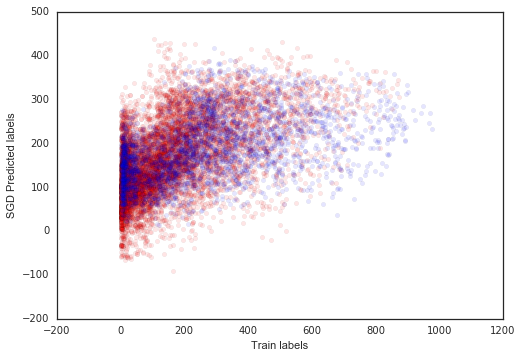

In [48]:
plt.scatter(train_labels, sgd_grid_est.predict(train_data), c="r", alpha=0.1)
plt.scatter(test_labels, sgd_grid_est.predict(test_data), c="b", alpha=0.1)
plt.xlabel("Train labels")
plt.ylabel("SGD Predicted labels")

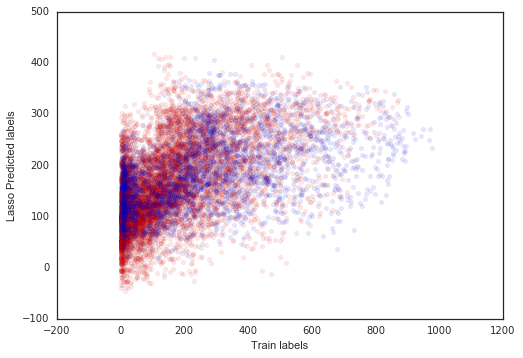

In [49]:
plt.scatter(train_labels, lasso_grid_est.predict(train_data), c="r", alpha=0.1)
plt.scatter(test_labels, lasso_grid_est.predict(test_data), c="b", alpha=0.1)
plt.xlabel("Train labels")
plt.ylabel("Lasso Predicted labels")

Ответы алгоритма и реальные ответы слабо коррелируют, поэтому можно сделать предположение о том, что либо модель выбрана неправильно, либо неправильно выбраны признаки. В целом модель мы получили отвратительную

### Случайный лес

In [51]:
from sklearn.ensemble import RandomForestRegressor

rgr = RandomForestRegressor()
rgr.fit(train_data, train_labels)
print(metrics.mean_absolute_error(train_labels, rgr.predict(train_data)))
print(metrics.mean_absolute_error(test_labels, rgr.predict(test_data)))

10.7965069196
52.4454192654


In [55]:
print(np.argsort(rgr.feature_importances_))
print(rgr.feature_importances_)

[1 7 3 0 6 2 8 4 5 9]
[ 0.02903561  0.00495351  0.0635583   0.02044625  0.07745208  0.08655277
  0.03794696  0.01680044  0.06477281  0.59848127]


Наибольший вклад внесли признаки "holiday", "season" и "temp". Не совсем соответствует моим ожиданиям: не думал, что такая сильная зависимость от температуры.

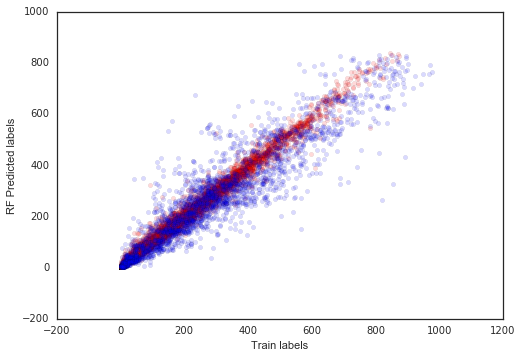

In [57]:
plt.scatter(train_labels, rgr.predict(train_data), c="r", alpha=0.15)
plt.scatter(test_labels, rgr.predict(test_data), c="b", alpha=0.15)
plt.xlabel("Train labels")
plt.ylabel("RF Predicted labels")

Аггрегация деревьев на данной выборке и признаках лучше подходит для построения регрессии чем линейные модели.

### Опциональная часть

Попробуйте улучшить результат, полученный на предыдущих шагах. В этом разделе можно и нужно пользоваться любыми изученными алгоритмами, инструментами и всем, чем вам захочется.

Нет времени:( Попробую сделать позже

### Заключение

В этом разделе Вы можете написать, какие выводы Вы сделали в процессе работы над заданием, понравилось ли оно Вам, а также всё, что Вы о задании думаете =)

Задание получилось очень интересным и поучительным. Очень жаль, что вы ведете у нас так мало семинаров. Думаю, вы можете еще много интересного нам рассказать. Спасибо за этот маленький курс!